In [1]:
### 특정 컬럼 삭제 ###
# df = df.drop(['Unnamed: 0','timestamp'], axis= 1)


### DataFrame To csv ###
# df.to_csv('C:/Users/KETI/grc_v1.0/data_real.csv', index = None)


### 리스트 내 element 존재 여부 검사 ###
# if 0 in label:
#     print("True")
# else :
#     print("X")


### 두 파일 합치기 ###

# 파일 경로 설정
# real_csv_path = output_dir + 'real_class_8.csv'
# simulated_csv_path = output_dir + 'simulated_class_8.csv'
# combined_csv_path = output_dir + 'combined_class_8.csv'

# # 각 파일을 데이터프레임으로 불러오기
# real_df = pd.read_csv(real_csv_path)
# simulated_df = pd.read_csv(simulated_csv_path)

# # 두 데이터프레임 합치기
# combined_df = pd.concat([real_df, simulated_df], ignore_index=True)

# # 합쳐진 데이터프레임을 새로운 CSV 파일로 저장
# combined_df.to_csv(combined_csv_path, index=False)

# print(f"Combined CSV saved to {combined_csv_path}")


### class 별로 나누어 각기 다른 csv로 저장 ###

# # 주어진 class 값 목록과 그룹
# class_groups = {
#     (1, 101): "class_1",
#     (2, 102): "class_2",
#     (5, 105): "class_5",
#     (6, 106): "class_6",
#     (7, 107): "class_7",
#     (8, 108): "class_8",
#     (0,): "class_0",
#     (3,): "class_3",
#     (4,): "class_4"
# }

# # 각 class 그룹에 따라 데이터프레임 필터링 및 별도의 CSV 파일로 저장
# for classes, group_name in class_groups.items():
#     class_df = df[df['class'].isin(classes)]
    
#     # 선택된 행을 새로운 CSV 파일로 저장
#     output_file = f"{output_dir}/real_{group_name}.csv"
#     class_df.to_csv(output_file, index=False)

# print("Files saved successfully!")


### 데이터의 수를 맞춘 BALANCED_DATA로 Re-Constructed ###

## CSV 파일 불러오기
#df = pd.read_csv('combined_train_file.csv')

## "t-tpt" 컬럼 제거
#df = df.drop(columns=['T-TPT'])

## 각 클래스별 데이터 수 세기
#class_counts = df['class'].value_counts()

## 가장 작은 데이터 양 찾기
#min_count = class_counts.min()

## 0번 클래스 데이터: min_count의 2배 만큼 뽑기
## 0번 클래스의 데이터 양이 2 * min_count 보다 적으면 그만큼만 뽑습니다.
#class_0_data = df[df['class'] == 0].sample(n=min(2 * min_count, class_counts[0]))

## 다른 클래스 데이터: min_count만큼 뽑기
#other_classes_data = pd.concat(
#    [df[df['class'] == cls].sample(min_count) for cls in class_counts.index if cls != 0]
#)

## 데이터 합치기
#balanced_data = pd.concat([class_0_data, other_classes_data])

## 결과 확인
#print(balanced_data['class'].value_counts())

## 필요한 경우, balanced_data를 새로운 CSV 파일로 저장
#balanced_data.to_csv('C:/Users/KETI/grc/balanced_data.csv', index=False)


### Make TestSet ###

# # CSV 파일 불러오기
# df = pd.read_csv('combined_train_file.csv')

# # "t-tpt" 컬럼 제거
# df = df.drop(columns=['T-TPT'])

# # 이미 뽑힌 데이터 제거
# # 이전에 balanced_data를 생성한 후, 이를 다시 저장하셨다면 그 파일을 불러와서 제거해야 합니다.
# balanced_already = pd.read_csv('balanced_data.csv')  # 이미 뽑힌 데이터 불러오기
# df = df.drop(balanced_already.index)

# # 각 클래스별로 1000개씩 데이터 뽑기
# sample_count = 1000
# sampled_data = pd.concat([df[df['class'] == cls].sample(min(sample_count, len(df[df['class'] == cls])), replace=False) for cls in df['class'].unique()])

# # 결과 확인
# print(sampled_data['class'].value_counts())

# # 필요한 경우, sampled_data를 새로운 CSV 파일로 저장
# sampled_data.to_csv('C:/Users/KETI/grc/test.csv', index=False)

In [2]:
import pandas as pd 
import numpy as np
import os
import csv
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Input, TimeDistributed, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
# gpu 할당 및 메모리 순차적 증가 설정 -> 메모리 과다 사용 방지
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
 try:
    # 첫 번째 GPU만 사용하도록 설정
    for gpu in gpus:
        # 각 GPU에 대한 메모리 제한 설정
        tf.config.experimental.set_virtual_device_configuration(
            gpu,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)])  # 여기에 원하는 메모리 제한 크기를 MB 단위로 설정하세요.
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    #for gpu in gpus:
            #tf.config.experimental.set_memory_growth(gpu, True)
 except RuntimeError as e:
    # GPU가 설정되어 있지 않은 경우 오류가 발생할 수 있습니다.
    print(e)


2 Physical GPUs, 2 Logical GPU


In [12]:
    X = []
    Y = []
    p_pdg = []
    p_tpt = []
    t_tpt = []
    p_mon_ckp = []
    t_jus_ckp = []
    p_jus_ckgl = []
    label = []
    segment_sec = 5
    
    with open('balanced_data.csv', 'r') as file:
        #df = pd.read_csv(file)
        csv_reader = csv.DictReader(file)    
        for csv_data in csv_reader:
            for key, val in csv_data.items():
                if key == "P-PDG":
                    p_pdg.append(float(val))
                elif key == "P-TPT":
                    p_tpt.append(float(val))
                elif key == "T-TPT":
                    t_tpt.append(float(val))
                elif key == "P-MON-CKP":
                    p_mon_ckp.append(float(val))
                elif key == "T-JUS-CKP":
                    t_jus_ckp.append(float(val))
                elif key == "P-JUS-CKGL":
                    p_jus_ckgl.append(float(val))
                elif key == "class":
                    if val == '0':
                        label.append(0)
                    elif val == '1':
                        label.append(1)
                    elif val == '101':
                        label.append(1)
                    elif val == '2':
                        label.append(2)
                    elif val == '102':
                        label.append(2)
                    elif val == '3':
                        label.append(3)
                    elif val == '4':
                        label.append(4)
                    elif val == '5':
                        label.append(5)
                    elif val == '105':
                        label.append(5)
                    elif val == '6':
                        label.append(6)
                    elif val == '106':
                        label.append(6)
                    elif val == '7':
                        label.append(7)
                    elif val == '107':
                        label.append(7)
                    elif val == '8':
                        label.append(8)
                    elif val == '108':
                        label.append(8)

In [13]:
# Data concat 
# Simulated = P-PDG, P-TPT, P-MON-CKP, T-JUS-CKP
# well = P-PDG, P-TPT, T-TPT, P-MON-CKP, T-JUS-CKP, P-JUS-CKGL

p_pdg                = np.expand_dims(p_pdg, axis = 1)
p_tpt                = np.expand_dims(p_tpt, axis = 1)
#t_tpt                = np.expand_dims(t_tpt, axis = 1)
p_mon_ckp            = np.expand_dims(p_mon_ckp, axis = 1)
t_jus_ckp            = np.expand_dims(t_jus_ckp, axis = 1)
#p_jus_ckgl           = np.expand_dims(p_jus_ckgl, axis = 1)

    
# Label
label              = np.expand_dims(label, axis = 1)
    
# Real Data Concat
#concat_data        = np.concatenate((p_pdg, p_tpt, t_tpt, p_mon_ckp, t_jus_ckp, p_jus_ckgl), axis = 1)

# Simulated Data Concat
concat_data        = np.concatenate((p_pdg, p_tpt, p_mon_ckp, t_jus_ckp), axis = 1)

In [14]:
# segment_sec를 간격으로 하나의 데이터 세트로 생성
X = np.array([ concat_data[i:i+5] for i in range(0, len(concat_data) - segment_sec, segment_sec) ])
        
# segment_sec를 간격으로  하나의 Label을 생성.
Y = np.expand_dims([stats.mode(label[i:i+segment_sec])[0][0] for i in range(0, len(concat_data) - segment_sec, segment_sec)], axis=1)

In [15]:
X = np.array(X)
Y = np.array(Y)

In [16]:
Y

array([[[0]],

       [[0]],

       [[0]],

       ...,

       [[7]],

       [[7]],

       [[7]]])

In [17]:
np.shape(X)

(82783, 5, 4)

In [18]:
np.shape(Y)

(82783, 1, 1)

In [19]:
Y = tf.keras.utils.to_categorical(Y) # one-hot encoding

In [27]:
np.shape(X)

(82783, 5, 4)

In [26]:
np.shape(Y)

(82783, 9)

In [25]:
Y = Y.reshape(-1,9)

In [28]:
shape = X.shape
reshape_X = np.reshape(X,(shape[0] * shape[1] ,shape[2]))

avg = np.mean(reshape_X, axis=0)

In [29]:
shape = X.shape
reshape_X = np.reshape(X,(shape[0] * shape[1] ,shape[2]))

std = np.std(reshape_X, axis=0)

In [30]:
# X와 Y의 위치를 유지하며 random으로 섞기
idxs = np.arange(X.shape[0])
np.random.shuffle(idxs)

Y = Y[idxs]
X = X[idxs]

In [31]:
X = (X - avg) / std

In [32]:
X

array([[[-2.95060361e+00,  3.81257011e-02,  2.19904487e+00,
         -3.54358175e-01],
        [-2.95060361e+00,  3.76459385e-02,  2.18805153e+00,
         -3.50488232e-01],
        [-2.95060361e+00,  3.78858198e-02,  2.19856823e+00,
         -3.57866597e-01],
        [-2.95060361e+00,  3.74060572e-02,  2.19433107e+00,
         -3.52971497e-01],
        [-2.95060361e+00,  2.94902155e-02,  1.73222286e+00,
         -7.09430995e-02]],

       [[ 3.38913704e-01, -1.32289730e-02, -9.35565126e-01,
          9.43408975e-01],
        [ 3.38913704e-01, -1.15155142e-01, -8.97796480e-01,
          1.89960419e-01],
        [ 3.38913704e-01, -4.77848633e-02, -9.65922482e-01,
          3.96605294e-01],
        [ 3.38913704e-01, -4.91891608e-02,  3.43125372e-01,
         -8.45212444e-02],
        [ 3.38913704e-01, -1.21567836e-01, -9.77925922e-01,
          1.13813039e-01]],

       [[ 3.38913704e-01, -1.33160775e-01, -2.24931800e-01,
          1.74362207e-01],
        [ 3.38913704e-01, -1.38908739e-

In [33]:
Y

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [34]:
np.shape(X)

(82783, 5, 4)

In [35]:
np.shape(Y)

(82783, 9)

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=777, stratify=Y)

In [47]:
# Epochs : 300 over -> Overfitting

input_shape = (5,4)
batch_size = 64
epochs = 300

lstm_input = Input(shape = (input_shape))
lstm = TimeDistributed(Dense(20, activation = "relu"))(lstm_input)
lstm = BatchNormalization()(lstm)
lstm = LSTM(30, return_sequences = True)(lstm)
lstm = Dropout(0.5)(lstm)
lstm = LSTM(20)(lstm)
lstm = Dropout(0.5)(lstm)
lstm = Dense(10, activation = "relu")(lstm) 
lstm = Dense(9, activation = "softmax")(lstm)
    
model = Model(inputs = lstm_input, outputs = lstm)
    
opt = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [48]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5, 4)]            0         
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 20)            100       
 tributed)                                                       
                                                                 
 batch_normalization_2 (Batc  (None, 5, 20)            80        
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 5, 30)             6120      
                                                                 
 dropout_4 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                4080

In [49]:
np.shape(X_train)

(57948, 5, 4)

In [50]:
np.shape(Y_train)

(57948, 9)

In [51]:
history = model.fit(X_train, Y_train, batch_size = batch_size, epochs=epochs, validation_data=(X_test, Y_test))

Epoch 1/300
906/906 [==============================] - 19s 19ms/step - loss: 2.1793 - accuracy: 0.1483 - val_loss: 2.1402 - val_accuracy: 0.1717
Epoch 2/300
906/906 [==============================] - 17s 18ms/step - loss: 2.1144 - accuracy: 0.1838 - val_loss: 2.0623 - val_accuracy: 0.2338
Epoch 3/300
906/906 [==============================] - 16s 18ms/step - loss: 2.0417 - accuracy: 0.2073 - val_loss: 1.9791 - val_accuracy: 0.3169
Epoch 4/300
906/906 [==============================] - 16s 18ms/step - loss: 1.9701 - accuracy: 0.2276 - val_loss: 1.8971 - val_accuracy: 0.3322
Epoch 5/300
906/906 [==============================] - 17s 18ms/step - loss: 1.9024 - accuracy: 0.2522 - val_loss: 1.8210 - val_accuracy: 0.3616
Epoch 6/300
906/906 [==============================] - 16s 18ms/step - loss: 1.8374 - accuracy: 0.2764 - val_loss: 1.7480 - val_accuracy: 0.4004
Epoch 7/300
906/906 [==============================] - 16s 18ms/step - loss: 1.7801 - accuracy: 0.3024 - val_loss: 1.6818 - val_ac

In [52]:
filename = "my_model"

# 훈련된 모델과 파라미터를 저장할 폴더 생성
os.mkdir(filename)
    
# inference 시 z score normalization에 사용될 평균과 표준편차 저장
np.save(filename + "/" + filename + "_avg.npy", avg)
np.save(filename + "/" + filename + "_std.npy", std)
    
model.save(filename + "/" + filename + ".h5")

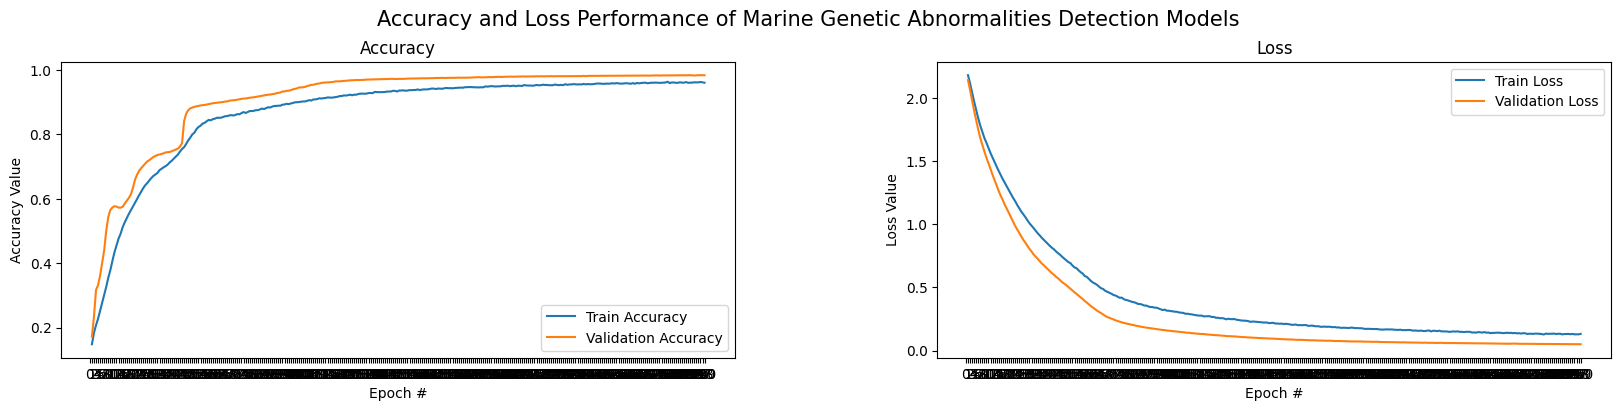

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Accuracy and Loss Performance of Marine Genetic Abnormalities Detection Models ', fontsize=15)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [86]:
    X_ = []
    Y_ = []
    p_pdg_ = []
    p_tpt_ = []
    t_tpt_ = []
    p_mon_ckp_ = []
    t_jus_ckp_ = []
    p_jus_ckgl_ = []
    concat_data_ = []
    label_ = []
    segment_sec = 5
    
    with open('test.csv', 'r') as file:
        #df = pd.read_csv(file)
        csv_reader = csv.DictReader(file)    
        for csv_data in csv_reader:
            for key, val in csv_data.items():
                if key == "P-PDG":
                    p_pdg_.append(float(val))
                elif key == "P-TPT":
                    p_tpt_.append(float(val))
                elif key == "T-TPT":
                    t_tpt_.append(float(val))
                elif key == "P-MON-CKP":
                    p_mon_ckp_.append(float(val))
                elif key == "T-JUS-CKP":
                    t_jus_ckp_.append(float(val))
                elif key == "P-JUS-CKGL":
                    p_jus_ckgl_.append(float(val))
                elif key == "class":
                    if val == '0':
                        label_.append(0)
                    elif val == '1':
                        label_.append(1)
                    elif val == '101':
                        label_.append(1)
                    elif val == '2':
                        label_.append(2)
                    elif val == '102':
                        label_.append(2)
                    elif val == '3':
                        label_.append(3)
                    elif val == '4':
                        label_.append(4)
                    elif val == '5':
                        label_.append(5)
                    elif val == '105':
                        label_.append(5)
                    elif val == '6':
                        label_.append(6)
                    elif val == '106':
                        label_.append(6)
                    elif val == '7':
                        label_.append(7)
                    elif val == '107':
                        label_.append(7)
                    elif val == '8':
                        label_.append(8)
                    elif val == '108':
                        label_.append(8)

In [87]:
    # Data concat 
    # Simulated = P-PDG, P-TPT, P-MON-CKP, T-JUS-CKP
    # Real = P-PDG, P-TPT, T-TPT, P-MON-CKP, T-JUS-CKP, P-JUS-CKGL
    
    p_pdg_                = np.expand_dims(p_pdg_, axis = 1)
    p_tpt_                = np.expand_dims(p_tpt_, axis = 1)
    #t_tpt                = np.expand_dims(t_tpt, axis = 1)
    p_mon_ckp_            = np.expand_dims(p_mon_ckp_, axis = 1)
    t_jus_ckp_            = np.expand_dims(t_jus_ckp_, axis = 1)
    #p_jus_ckgl           = np.expand_dims(p_jus_ckgl, axis = 1)
       
    # Real Data Concat
    #concat_data        = np.concatenate((p_pdg, p_tpt, t_tpt, p_mon_ckp, t_jus_ckp, p_jus_ckgl), axis = 1)
    
    # Simulated Data Concat
    concat_data_        = np.concatenate((p_pdg_, p_tpt_, p_mon_ckp_, t_jus_ckp_), axis = 1)
    
    # Label
    label_              = np.expand_dims(label_, axis = 1)

In [88]:
# segment_sec를 간격으로 하나의 데이터 세트로 생성
X_ = np.array([ concat_data_[i:i+5] for i in range(0, len(concat_data_) - segment_sec, segment_sec) ])

# segment_sec를 간격으로 하나의 Label을 생성.
Y_ = np.expand_dims([stats.mode(label_[i:i+segment_sec])[0][0] for i in range(0, len(concat_data_) - segment_sec, segment_sec)], axis=1)

In [89]:
X_ = np.array(X_)

In [90]:
Y_ = np.array(Y_)

In [91]:
np.shape(X_)

(2999, 5, 4)

In [95]:
np.shape(Y_)

(2999, 9)

In [93]:
Y_ = tf.keras.utils.to_categorical(Y_) # one-hot encoding

In [94]:
Y_ = Y_.reshape(-1,9)

In [63]:
shape = X_.shape
reshape_X_ = np.reshape(X_,(shape[0] * shape[1] ,shape[2]))

avg_ = np.mean(reshape_X_, axis=0)

In [64]:
avg_

array([-1.26235816e+41,  1.82603314e+07,  4.86420903e+06,  7.13717202e+01])

In [65]:
shape = X_.shape
reshape_X_ = np.reshape(X_,(shape[0] * shape[1] ,shape[2]))

std_ = np.std(reshape_X_, axis=0)

In [66]:
std_

array([3.64742958e+41, 7.94326606e+07, 3.57579675e+06, 2.84608294e+01])

In [67]:
X_ = (X_ - avg_) / std_

In [68]:
np.shape(X_)

(2999, 5, 4)

In [69]:
y_predict = model.predict(X_)

94/94 [==============================] - 1s 5ms/step


In [71]:
print (y_predict)

[[9.9889648e-01 7.5325763e-05 2.3687526e-05 ... 4.7635072e-05
  6.8079908e-07 3.1469806e-06]
 [9.9953413e-01 2.9060166e-04 4.5742868e-06 ... 2.7246293e-07
  1.6024488e-06 1.6502244e-07]
 [9.9948740e-01 5.5496261e-05 1.3490620e-05 ... 8.0333775e-06
  6.1714366e-07 1.2817219e-06]
 ...
 [1.1147847e-05 5.7319921e-10 3.9069511e-07 ... 3.2133261e-07
  1.1194236e-06 9.9993443e-01]
 [1.4237042e-05 8.9834457e-10 5.3779962e-07 ... 4.6574291e-07
  1.5382736e-06 9.9991584e-01]
 [1.2429900e-05 7.0839917e-10 4.4711149e-07 ... 3.9491857e-07
  1.2680190e-06 9.9992633e-01]]


In [105]:
y_predict_binary = (y_predict > 0.5).astype(int)

In [107]:
y_predict_binary

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [103]:
y_predict.shape

(2999, 9)

In [108]:
Y_.shape

(2999, 9)

In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(Y_, y_predict_binary, average='samples')
recall = recall_score(Y_, y_predict_binary, average='samples')
f1 = f1_score(Y_, y_predict_binary, average='samples')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.99
Recall: 0.99
F1 Score: 0.99
